In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from catboost import CatBoostClassifier
from xgboost import XGBRFClassifier

1. CARREGAMENTO DOS DADOS

In [2]:
df = pd.read_csv('customer_booking.csv')
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,261,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


2. ANÁLISE EXPLORATÓRIA

In [3]:
# Informação sobre a base de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [4]:
# Há dados ausentes, nulos?
df.isna().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [5]:
# Canais de compra da passagem
df.sales_channel.value_counts()

sales_channel
Internet    44382
Mobile       5618
Name: count, dtype: int64

In [6]:
# Tipo de viagem
df.trip_type.value_counts()

trip_type
RoundTrip     49497
OneWay          387
CircleTrip      116
Name: count, dtype: int64

<Axes: xlabel='trip_type', ylabel='count'>

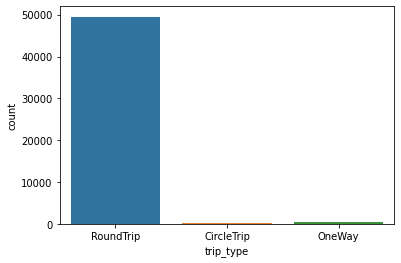

In [7]:
sns.countplot(df, x='trip_type')

<Axes: xlabel='booking_complete', ylabel='count'>

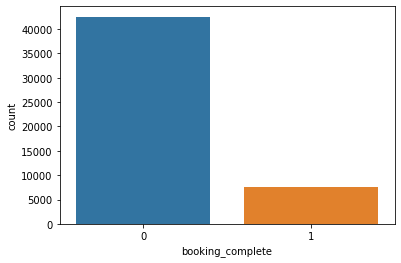

In [8]:
# Reservas completadas (0=não, 1=sim)
sns.countplot(df, x='booking_complete')

In [9]:
# Número de reservas por País

# Contar o número de reservas por país
country_counts = df['booking_origin'].value_counts()

# Criar um Dataframe a partir do objeto de contagem
df_country_counts = pd.DataFrame({'Country': country_counts.index, 'Count': country_counts.values})

# gráfico de barras
fig = px.bar(df_country_counts, x='Country', y='Count', title='Número de Reservas por País')
fig.update_layout(xaxis_tickangle=45)
fig.show()

3. PRÉ-PROCESSAMENTO

3.1 Transformar as variáveis categóricas nominais em categóricas ordinais

In [10]:
from sklearn.preprocessing import LabelEncoder

# lista das variáveis categóricas
var_cat = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']

# Aplicar LabelEncoder a cada coluna categórica
for col in var_cat:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [11]:
# verificando os tipos de dados após a transformação
df.dtypes

num_passengers             int64
sales_channel              int32
trip_type                  int32
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int32
route                      int32
booking_origin             int32
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

3.2 Variáveis preditoras e alvo

In [12]:
previsores = df.iloc[:, 0:13]
alvo = df.iloc[:, -1]

In [13]:
previsores.shape, alvo.shape

((50000, 13), (50000,))

3.3 Normalizar/Padronizar os dados

In [14]:
from sklearn.preprocessing import StandardScaler

previsores_esc = StandardScaler().fit_transform(previsores)

3.4 Redução da dimensionalidade

Objetivo é selecionar os melhores componentes (atributos) para treinamento do algoritmo, através da análise das correlações entre as variáveis

In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(n_components='mle')

In [17]:
previsores_pca = pca.fit_transform(previsores_esc)

In [18]:
previsores_pca

array([[-1.18932526e+00, -1.82596402e+00,  7.70700017e-01, ...,
         2.39344767e-01, -3.90154534e-01,  9.01897727e-01],
       [-1.93898339e+00,  1.40255831e-01,  9.21451903e-01, ...,
         8.00070392e-02,  5.51505614e-01,  1.04539315e+00],
       [ 2.08014882e-03, -2.12065671e+00,  2.09551730e-01, ...,
         2.81210133e-01, -7.87009983e-01,  2.43157653e+00],
       ...,
       [-5.88716209e-01,  1.03440216e+00, -8.07584322e-01, ...,
        -3.43480514e-01,  1.56796690e+00, -8.94825167e-02],
       [ 3.73615525e-01,  9.92829218e-01, -1.43694329e+00, ...,
        -6.44118701e-01,  4.71341170e-01, -4.64036597e-01],
       [-5.75457022e-01,  1.32006186e+00, -1.12398855e+00, ...,
         3.04633836e-01, -8.45158776e-02,  1.72858380e+00]])

3.5 Dados de treino e teste

In [41]:
X_train, X_test, y_train, y_test = train_test_split(previsores_esc, alvo, test_size=0.2, random_state=42)

## 4 RANDOM FOREST

4.1 Criar e treinar o modelo

In [42]:
rnd_model = RandomForestClassifier()
rnd_model.fit(X_train, y_train)

RandomForestClassifier()

4.2 Previsões com o modelo

In [43]:
rnd_prev = rnd_model.predict(X_test)

4.3 Avaliação do modelo

In [44]:
print(f'Acurácia: {accuracy_score(y_test, rnd_prev) *100:.2f}%\n')
print(f'Matriz de Confusão:\n {confusion_matrix(y_test, rnd_prev)}\n')
print(f'Relatório:\n {classification_report(y_test, rnd_prev)}')

Acurácia: 85.64%

Matriz de Confusão:
 [[8406  114]
 [1322  158]]

Relatório:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.58      0.11      0.18      1480

    accuracy                           0.86     10000
   macro avg       0.72      0.55      0.55     10000
weighted avg       0.82      0.86      0.81     10000



4.4 Conclusão sobre o modelo 

Embora a acurácia geral do modelo seja relativamente alta (85.58%), a análise da matriz de confusão e do relatório de classificação revela uma clara dificuldade do modelo em identificar corretamente a classe 1 (positiva). Isso é evidenciado pelo baixo recall (0.10) e baixo F1-score (0.18) para a classe 1.

Esses resultados sugerem que, apesar de o modelo ser eficaz em identificar a classe negativa, ele não é bom em detectar casos positivos, o que pode ser um problema se os casos positivos forem de particular interesse ou importância

## 5. XGBOOST

5.1 Criar e treinar o modelo

In [26]:
xg = XGBRFClassifier(max_depth=6, learning_rate=0.05, n_estimators=250, objective='binary:logistic', random_state=3)
xg.fit(X_train, y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.05, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=6, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=250, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=3, ...)

5.2 Previsões

In [27]:
xg_prev = xg.predict(X_test)

5.3 Avaliação do modelo

In [28]:
print(f'Acurácia: {accuracy_score(y_test, xg_prev) *100:.2f}%\n')
print(f'Matriz de Confusão:\n {confusion_matrix(y_test, xg_prev)}\n')
print(f'Relatório:\n {classification_report(y_test, xg_prev)}')

Acurácia: 85.20%

Matriz de Confusão:
 [[8520    0]
 [1480    0]]

Relatório:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      8520
           1       0.00      0.00      0.00      1480

    accuracy                           0.85     10000
   macro avg       0.43      0.50      0.46     10000
weighted avg       0.73      0.85      0.78     10000



c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



5.4 Conclusão sobre o modelo

Os resultados do modelo XGBoost indicam um problema significativo de desempenho, especialmente na capacidade do modelo de identificar corretamente os casos da classe positiva(1)

O modelo XGBoost, apesar de ter uma acurácia total semelhante ao Random Forest Classifier, revelou-se extremamente ineficaz para prever a classe positiva (1), não identificando corretamente nenhum caso positivo. Isso indica que o modelo é altamente enviesado para a classe mais representativa (0), possivelmente devido a um desbalanceamento significativo de classes no conjunto de dados.

## 6. CATBOOST

6.1 Criar e treinar o modelo

In [29]:
cat = CatBoostClassifier(task_type='CPU', iterations=120, learning_rate=0.1, depth=8, random_state=5, eval_metric='Accuracy')
cat.fit(X_train, y_train)

0:	learn: 0.8501000	total: 158ms	remaining: 18.8s
1:	learn: 0.8500500	total: 167ms	remaining: 9.83s
2:	learn: 0.8500500	total: 174ms	remaining: 6.79s
3:	learn: 0.8500500	total: 182ms	remaining: 5.29s
4:	learn: 0.8500500	total: 195ms	remaining: 4.49s
5:	learn: 0.8500500	total: 198ms	remaining: 3.76s
6:	learn: 0.8500500	total: 206ms	remaining: 3.32s
7:	learn: 0.8500500	total: 218ms	remaining: 3.06s
8:	learn: 0.8500500	total: 221ms	remaining: 2.73s
9:	learn: 0.8500500	total: 228ms	remaining: 2.51s
10:	learn: 0.8500500	total: 234ms	remaining: 2.32s
11:	learn: 0.8500500	total: 240ms	remaining: 2.16s
12:	learn: 0.8500500	total: 246ms	remaining: 2.02s
13:	learn: 0.8500500	total: 252ms	remaining: 1.91s
14:	learn: 0.8500500	total: 258ms	remaining: 1.81s
15:	learn: 0.8500500	total: 264ms	remaining: 1.71s
16:	learn: 0.8500500	total: 270ms	remaining: 1.64s
17:	learn: 0.8500500	total: 277ms	remaining: 1.57s
18:	learn: 0.8501250	total: 283ms	remaining: 1.5s
19:	learn: 0.8501000	total: 290ms	remainin

5.2 Previsões

In [30]:
cat_prev = cat.predict(X_test)

5.3 Avaliação 

In [31]:
print(f'Acurácia: {accuracy_score(y_test, cat_prev) *100:.2f}%\n')
print(f'Matriz de Confusão:\n {confusion_matrix(y_test, cat_prev)}\n')
print(f'Relatório:\n {classification_report(y_test, cat_prev)}')

Acurácia: 85.31%

Matriz de Confusão:
 [[8483   37]
 [1432   48]]

Relatório:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92      8520
           1       0.56      0.03      0.06      1480

    accuracy                           0.85     10000
   macro avg       0.71      0.51      0.49     10000
weighted avg       0.81      0.85      0.79     10000



Concluindo, parece haver classes desbalancedas nesse conjunto de dados e os 3 algoritmos usados (random forest, xgboost e catboos) não lidam muito bem com elas, então vou optar por usar o BalancedRandomForestClassifier, que é uma implementação do Random Forest que lida automaticamente com o desbalanceamento de classes, ajustando os pesos das classes durante o treinamento.

In [45]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [46]:
# Inicialize o BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

# Treine o modelo
brf.fit(X_train, y_train)

# Faça previsões
y_pred = brf.predict(X_test)

# Avalie o modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning:

The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.

c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning:

The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.



[[5755 2765]
 [ 336 1144]]
              precision    recall  f1-score   support

           0       0.94      0.68      0.79      8520
           1       0.29      0.77      0.42      1480

    accuracy                           0.69     10000
   macro avg       0.62      0.72      0.61     10000
weighted avg       0.85      0.69      0.73     10000



Conclusão 

A aplicação do BalancedRandomForestClassifier alterou significativamente o equilíbrio entre precisão e recall, favorecendo a detecção da classe minoritária. Isso é evidenciado pelo aumento no recall da classe 1 para 0.77, um indicativo de que o modelo se tornou muito mais eficaz em identificar a classe minoritária, embora à custa de um aumento nos falsos positivos (como visto no FP para a classe 0).

A acurácia geral do modelo diminuiu para 69%, o que reflete o compromisso entre aumentar a detecção da classe minoritária e manter a precisão geral

Embora o BalancedRandomForestClassifier tenha diminuído a acurácia geral, ele conseguiu melhorar significativamente a identificação da classe minoritária.